# 🐶 End-to-end Multi-class Dog Breed Classification

1. Problem

- Identifying the breed of a dog given an image of a dog. 
- When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

2. Data

- The data we're using is from Kaggle's dog breed identification competition.
- Dataset: https://www.kaggle.com/c/dog-breed-identification/data

3. Evaluation
- The evaluation is a file with prediction probabilities for each dog breed of each test image.
- Evaluation: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

4. Features
- Some information about the data:
    1. We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
    2. There are 120 breeds of dogs (this means there are 120 different classes).
    3. There are around 10,000+ images in the training set (these images have labels).
    4. There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them)

# Check Tensorflow & Tensorflow hub version and make sure GPU is available

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
print("Tensorflow version: ", tf.__version__)
print("Tensorflow_hub version: ", hub.__version__)

Tensorflow version:  2.10.0
Tensorflow_hub version:  0.12.0


In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Print Libraries & Load Data

In [3]:
import pandas as pd
import numpy as np

labels_csv = pd.read_csv("labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


<Axes: xlabel='breed'>

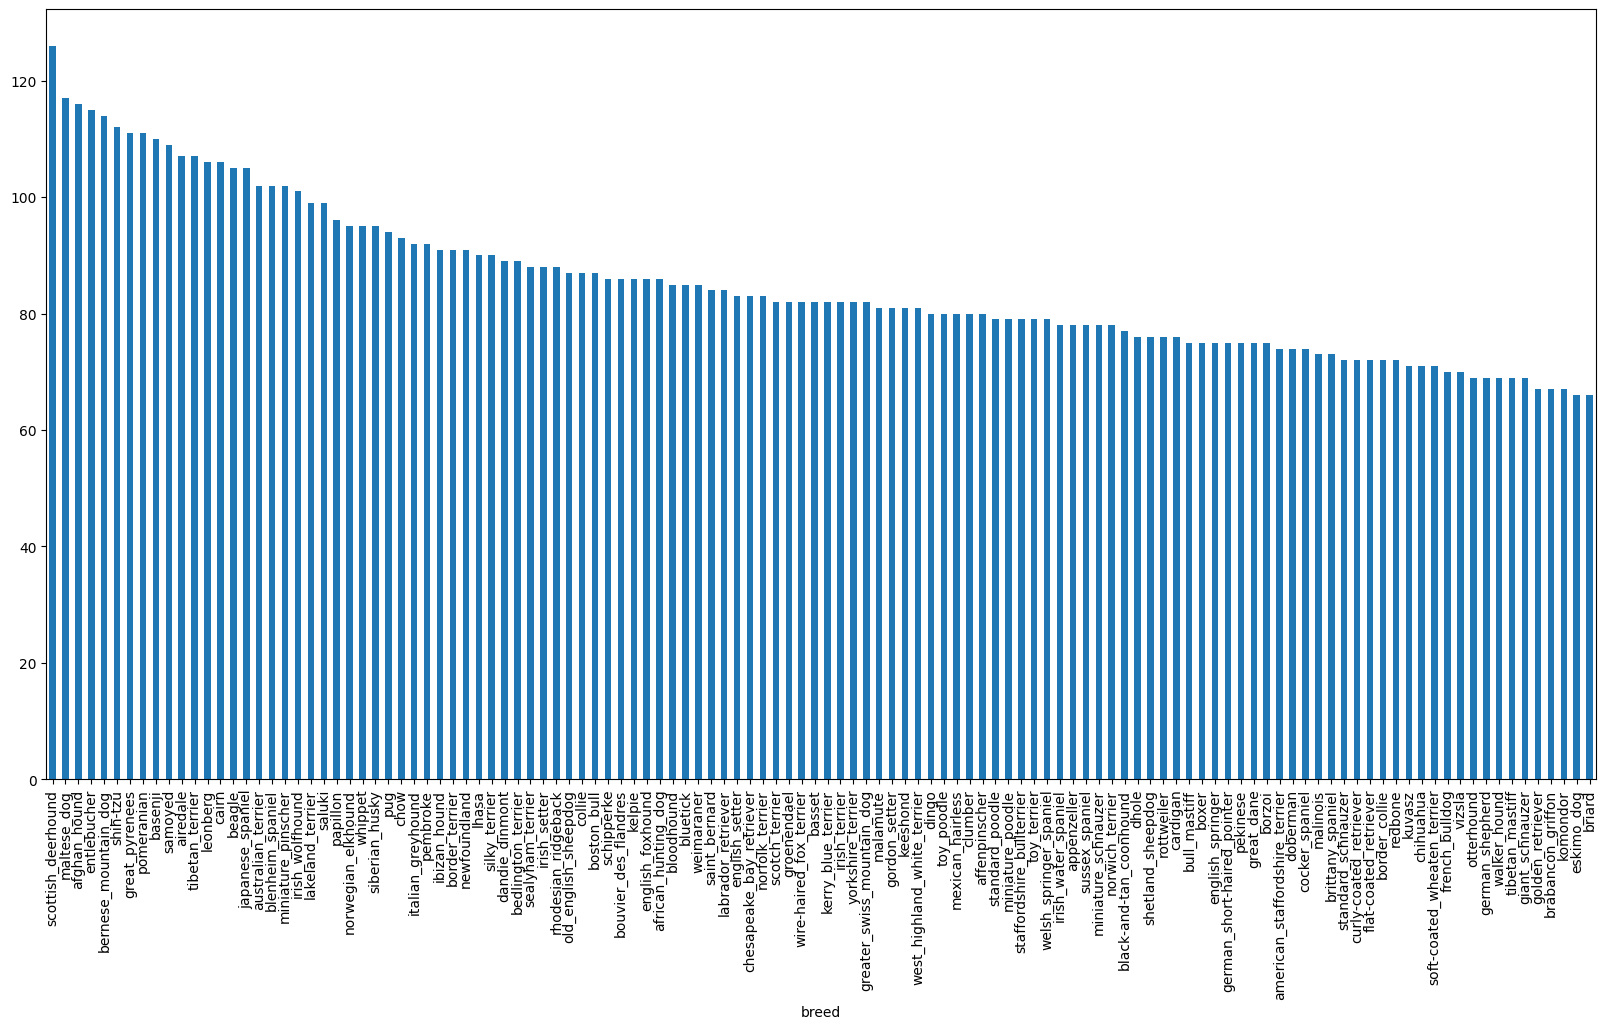

In [5]:
labels_csv['breed'].value_counts().plot.bar(figsize =(20,10))

In [6]:
labels_csv['breed'].value_counts().mean()

85.18333333333334

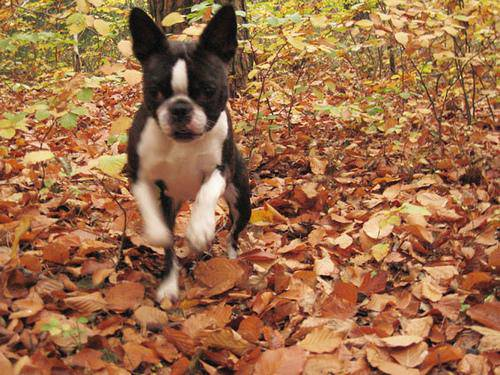

In [7]:
# Lets try look an example of dog picture

from IPython.display import Image
Image("train/000bec180eb18c7604dcecc8fe0dba07.jpg")

# Get images and their label

In [8]:
label_id = ["train/" + fname + ".jpg" for fname in labels_csv['id']]
label_id[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
import os
if len(os.listdir("train/")) == len(label_id):
    print("We're good to go")
else:
    print("Data don't match")

We're good to go


In [10]:
labels = labels_csv['breed'].to_numpy()
unique_breeds = np.unique(labels)

In [11]:
boolean_labels = [unique_breeds == labels for labels in labels]
len(boolean_labels)
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [12]:
X = label_id
y = boolean_labels

num_images = 1000
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:num_images], y[:num_images], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

# Preprocessing Images


To preprocess image we need to write a function which does:
1. Take an image filepath as input
2. Use tensorflow to read the file and save it to a variable, `image`
3. Turn out `image` (a jpg) into Tensors
4. Normalize our image (convert colour channel from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

In [13]:
from matplotlib.pyplot import imread
image = imread(label_id[50])
image.shape

(240, 320, 3)

In [14]:
from tensorflow.io import read_file # type: ignore
from tensorflow.image import decode_jpeg, convert_image_dtype, resize # type: ignore

image_size = 224

# Image resizing function
def image_resizing(path):

    # Firstly we read the image path in byte (raw data)
    # Turn the image into numerical tensors with 3 colours channel to be proceed by TF
    # Convert image dtype from uint8(0-255) to float(0-1) to helps model performance
    # Change the image size into [224,224] for consistant size

    image = read_file(path)
    image = decode_jpeg(image)
    image = convert_image_dtype(image, tf.float32)
    image = resize(image, size=[image_size, image_size]) #method=(bilinear) -nearest, bicubic etc

    return image


# Turning Data Into Batches

In [15]:
def get_image_label(path, label):
    image = image_resizing(path)
    return image, label

In [16]:
batch_size = 32

def create_data_batch(X, y=None, batch_size = batch_size, valid_data=False, test_data=False):

    """
    Create Data batches 
    Training data: we do shuffle and input x & y
    Validation data: we dont shuffle but input x & y, 
    Test data: we input x data (no labels)
    """

    # For test data
    if test_data:
        print("Creating Test Data....")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(image_resizing).batch(batch_size)
        return data_batch
    
    elif valid_data:
        print("Creating Validation Data....")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
    
    else:
        print("Creating Train Data....")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch    

In [17]:
# Create Training and Validation data batches

train_data = create_data_batch(X_train, y_train)
val_data = create_data_batch(X_val, y_val, valid_data=True)

Creating Train Data....
Creating Validation Data....


In [18]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing out train & valid data

In [19]:
import matplotlib.pyplot as plt

def show_25_images(images, label):
    plt.figure(figsize=(10,15))

    for i in range(25):
        ax = plt.subplot(5,5, i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[label[i].argmax()])
        plt.axis('off')
        plt.tight_layout()

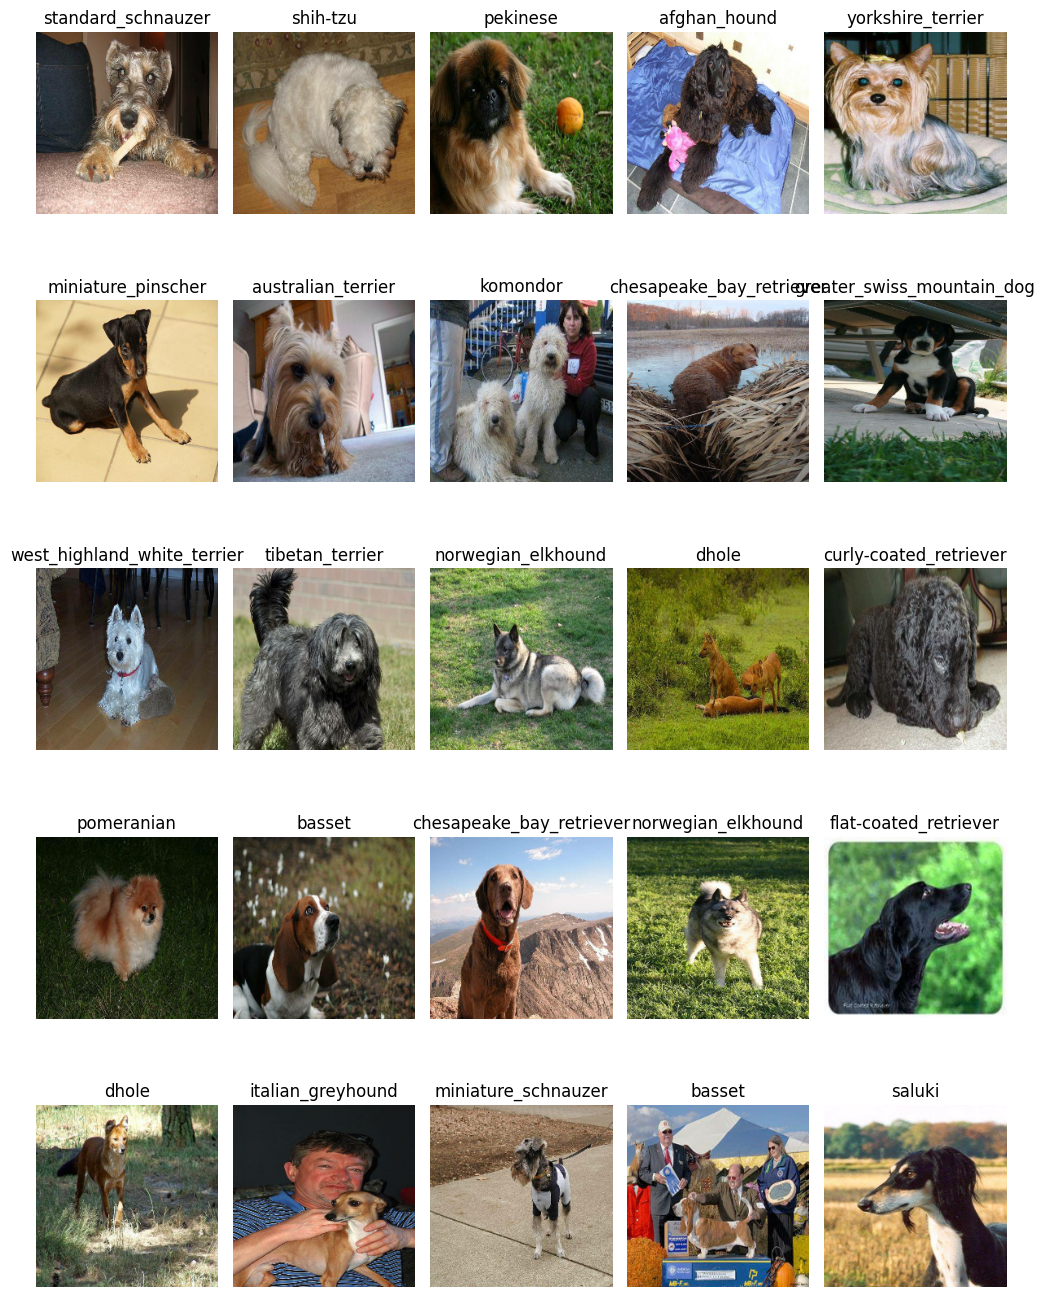

In [20]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

# Building the Model

Before we build a model, there are a few things we need to define:

- The input shape (images, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors) of our model.
- The URL of the model we want to use.

In [21]:
# Setp input shape
input_shape = [None, image_size, image_size, 3] #batch, height, width, channel

# Setup output shape
output_shape = len(unique_breeds)

# Setup model url
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [22]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model(input_shape=input_shape, output_shape=output_shape, model_url=MODEL_URL):
    print("Building Model with: ", MODEL_URL)

    model = Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layer) & hidden layer inside the URL
        Dense(units=output_shape, activation='softmax') # Output Layer
    ])

    model.compile(loss=CategoricalCrossentropy(),
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    model.build(input_shape)
    return model

In [23]:
model = create_model()
model.summary()

Building Model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


OSError: SavedModel file does not exist at: C:\Users\asus\AppData\Local\Temp\tfhub_modules\87c08e811d90a898c320e6626614764b3f4e562b\{saved_model.pbtxt|saved_model.pb}

## Creating Callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

We will use 2 Callbacks: TensorBoard and EarlyStopping

### TensorBoard

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
# from tensorflow.keras.callbacks import TensorBoard 

# Create a function to build a tensorboard callback
def create_tensorboard():

    # Create a log directory for storing tensorboard logs
    logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    return tf.keras.callbacks.TensorBoard(logdir)

### EarlyStopping

Early Stopping helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."

In [ ]:
# from tf.keras.callbacks import EarlyStopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

## Training on Model

Our first model is only going to be trained on 1000 images. Trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

In [ ]:
#Check GPU Available
print("YES" if tf.config.list_physical_devices('GPU') else "Not Available")

Let's create a simple function which trains a model. The function will:
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [ ]:
num_epochs = 100

# Build train function to train and return a trained model
def train_model():

    # Create a model
    model = create_model()
    
    # Create a tensorboard
    tensorboard = create_tensorboard()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=num_epochs,
              validation_data=val_data,
              validation_freq=1, #Check validation metrics every epochs
              callbacks=[tensorboard, early_stopping])
    
    return model
    

In [ ]:
# Fit model to data

# Train 25 step = 800(train_data) / 32(batch), Val 7 step = 100(val_data) / 32(batch)
model = train_model()

**Question:** It looks like our model might be overfitting (getting far better results on the training set than the validation set), what are some ways to prevent model overfitting in a deep learning model?.

**Note:** Overfitting to begin with is a good thing. It means our model is learning something.

### Check Tensorboard

In [ ]:
%tensorboard --logdir ./logs

# Making and Evaluating predictions using trained model

In [ ]:
# Make predictions on validation data

predictions = model.predict(val_data, verbose = 1)
predictions

In [ ]:
print(predictions.shape)
print(len(y_val), len(unique_breeds))

In [ ]:
# First predictions

index = 0
#print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[index])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[index])}") # the index of where the max value in predictions[index] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}") # the predicted label

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Create get label Function
def get_pred_label(predictions_proba):
    label = np.argmax(predictions_proba)
    return unique_breeds[label]

Since our validation data is in batch form, we'll have to unbatch with (using `unbatch()`) and then turn it into an iterator using `as_numpy_iterator()` to make a predictions on validation images and then compare those to the validations label (truth labels)

In [ ]:
# Create unbatch Function

def unbatch_data(data):

    """
    Take a batch data of(images, labels) tensors and return seperate array of image and label
    """

    images = []
    labels = []

    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])

    return images, labels

val_images, val_label = unbatch_data(val_data)
    


Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer (index of sample).
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [ ]:

def plot_label(predict_proba, labels, images, n=1):

    pred_prob, true_label, image = predict_proba[n], labels[n], images[n]

    pred_label = get_pred_label(pred_prob)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"Predicted : {pred_label} {np.max(pred_prob)*100:.2f}% \nActual label : {true_label}", color = color)

In [ ]:
plot_label(predictions, val_label, val_images, n = 7)

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is predicting.

Let's build a function to demonstrate. The function will be:
* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_top_pred(predict_proba, labels, n=1):
    """
    Plot the top 10 prediction confidence along with the truth label for sample n
    """

    pred_prob, true_label = predict_proba[n], labels[n]

    # Find the top 10 index
    top_10_index = pred_prob.argsort()[-10:][::-1]
    # Find top 10 predictions value
    top_10_values = pred_prob[top_10_index]
    # Find top 10 predictions labels
    top_10_label = unique_breeds[top_10_index]

    # Set up plot
    top_plot = plt.bar(np.arange(len(top_10_label)),
                       top_10_values, color='grey')
    plt.xticks(np.arange(len(top_10_label)), labels = top_10_label, rotation = 'vertical')
    
    # Change true label's bar into green
    if np.isin(true_label, top_10_label):
        top_plot[np.argmax(top_10_label == true_label)].set_color('green')
    else:
        pass


In [ ]:
# Green labels is the true label, along with the probabilities as y axis

plot_top_pred(predictions, val_label, n=3)

Now lets create a function to visualize a few of our predictions and evaluate our model 

In [ ]:
def plot_some_pred(num_row, num_col):
    num_images = num_row * num_col

    plt.figure(figsize=(5*2*num_col, 5*num_row))
    for i in range(num_images):
        plt.subplot(num_row, 2*num_col, 2*i+1)
        # def plot_label(predict_proba, labels, images, n=1)
        plot_label(predictions, val_label, val_images, n=i)

        plt.subplot(num_row, 2*num_col, 2*i+2)
        # def plot_top_pred(predict_proba, labels, n=1)
        plot_top_pred(predictions, val_label, n=i)

        plt.tight_layout()

In [ ]:
plot_some_pred(4, 3)

# Saving and reloading trained model

In [ ]:
# Create a function to save model

def save_model(model, suffix=None):
    """ 
    Save a given model in models directory and appends a suffix
    """

    # Create a model directory path with current time
    modeldir = os.path.join("./models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = modeldir + "-" + suffix + ".h5" #save format of our model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

In [ ]:
# Create a function to load a trained model

def load_model(model_path):
    """ 
    Loads a saved model from a specified path.
    """

    print(f"Loading saved model from: {model_path}..")
    model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer})
    return model

In [ ]:
save_model(model, suffix='1000-images-mobilenetv2-Adam')

In [ ]:
load_1000_image_model = load_model("./models/20250221-010534-1000-images-mobilenetv2-Adam.h5")

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

# Evaluate the loaded model
load_1000_image_model.evaluate(val_data)


# Time to trainin a big dog model (Full data)

In [ ]:
len(X), len(y)

In [ ]:
# Create a data batch with the full data set

full_data = create_data_batch(X, y)

In [ ]:
# Create a model for full model

full_model = create_model()
full_model.summary()

In [ ]:
# Create a full model callback
full_model_tensorboard = create_tensorboard()

# No validation set when training on all data, so we can't monitor the validation accuracy
full_model_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)


In [ ]:
full_model.fit(x=full_data, 
               epochs=num_epochs,
               callbacks=[full_model_tensorboard, full_model_earlystopping])

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

In [ ]:
load_full_model = load_model("./models/20250221-013445-full-image-set-mobilenetv2-Adam.h5")

# Making prediction on test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [ ]:
test_path = "./test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
len(test_filenames)

In [ ]:
test_data = create_data_batch(test_filenames, test_data=True)

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = load_full_model.predict(test_data, verbose=1)

In [ ]:
np.savetxt("preds_data.csv", test_predictions, delimiter=",")

In [ ]:
test_predictions = np.loadtxt("preds_data.csv", delimiter=",")

In [ ]:
test_predictions[:10]

In [ ]:
test_predictions.shape

# Preparing test dataset for 

Looking at Kaggle sample submit, we wants our models prediction probability outputs in a DataFrame with an ID and a column for each dog breed
To do so, we'll:
- Create a pandas DataFrame with an ID columns as well as columns for each fog breed
- Add data to the ID column by extracting test image ID's from filepath
- Add prediction probabilities of each dog breed columns
- Export the DataFrame as csv

In [ ]:
# Create a pandas DataFrame

pred_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
pred_df

In [ ]:
pred_df['id']

In [ ]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
pred_df['id'] = test_ids
pred_df.head()

In [ ]:
pred_df[list(unique_breeds)] = test_predictions
pred_df.head()

In [ ]:
pred_df.to_csv("full_model_prediction.csv", index=False)